# Optimizing Marketing Expenses

We work for the analytical department at Yandex.Afisha and our task is is to help optimize marketing expenses. We've been provided with the following:
- Server logs with data on Yandex.Afisha visits from June 2017 through May 2018
- Dump file with all orders for the period
- Marketing expenses statistics

We will study:

- How people use the product
- When they start to buy
- How much money each customer brings
- When they pay off

# Table of Contents
[1 Open the data file and have a look at the general information](#1heading)  
&emsp;[1.1 Conclusion](#1.1heading)  
[2 Data preprocessing](#2heading)  
&emsp;[2.1 Processing missing values](#2.1heading)  
&emsp;[2.2 Data type replacement](#2.2heading)  
&emsp;[2.3 Processing duplicates](#2.3heading)  
&emsp;[2.4 Extra preprocessing](#2.4heading)  
[3 Analyze the Data](#3heading)  
&emsp;[3.1 Product](#3.1heading)   
&emsp;&emsp;[3.1.1 How many people use it every day, week and month?](#3.1.1heading)  
&emsp;&emsp;[3.1.2 How many sessions are there per day?](#3.1.2heading)  
&emsp;&emsp;[3.1.3 What is the length of each session?](#3.1.3heading)  
&emsp;&emsp;[3.1.4 How often do users come back?](#3.1.4heading)  
&emsp;[3.2 Sales](#3.2heading)  
&emsp;&emsp;[3.2.1 When do people start buying?](#3.2.1heading)  
&emsp;&emsp;[3.2.2 How many orders do customers make during a given period of time?](#3.2.2heading)  
&emsp;&emsp;[3.2.3 What is the average purchase size?](#3.2.3heading)  
&emsp;&emsp;[3.2.4 How much money do they bring? (LTV)](#3.2.4heading)  
&emsp;[3.3 Marketing](#3.3heading)  
&emsp;&emsp;[3.3.1 How much money was spent? Overall/per source/over time](#3.3.1heading)  
&emsp;&emsp;[3.3.2 How much did customer acquisition from each of the sources cost?](#3.3.2heading)  
&emsp;&emsp;[3.3.3 How worthwhile were the investments? (ROI)](#3.3.3heading)  
[4 Overall Conclusion](#4heading)

<a id='1heading'></a>

## Open the data files and have a look at the general information

In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as mt
import datetime as dt
import seaborn as sns
from math import factorial
from scipy import stats as st
from functools import reduce

In [2]:
#Read files
visits = pd.read_csv('/datasets/visits_log_us.csv')
orders = pd.read_csv('/datasets/orders_log_us.csv')
costs = pd.read_csv('/datasets/costs_us.csv')

In [3]:
#Check visits first five rows and the data info
display(visits.head())
print(visits.info())
print(visits.describe())

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
None
           Source Id           Uid
count  359400.000000  3.594000e+05
mean        3.750515  9.202557e+18
std         1.917116  5.298433e+18
min         1.000000  1.186350e+13
25%         3.000000  4.613407e+18
50%         4.000000  9.227413e+18
75%         5.000000  1.372824e+19
max        10.000000  1.844668e+19


In [4]:
#Check visits orders five rows and the data info
display(orders.head())
print(orders.info())
print(orders.describe())

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
None
            Revenue           Uid
count  50415.000000  5.041500e+04
mean       4.999647  9.098161e+18
std       21.818359  5.285742e+18
min        0.000000  3.135781e+14
25%        1.220000  4.533567e+18
50%        2.500000  9.102274e+18
75%        4.890000  1.368290e+19
max     2633.280000  1.844617e+19


In [5]:
#Check costs first five rows and the data info
display(costs.head())
print(costs.info())
print(costs.describe())

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB
None
         source_id        costs
count  2542.000000  2542.000000
mean      4.857199   129.477427
std       3.181581   156.296628
min       1.000000     0.540000
25%       2.000000    21.945000
50%       4.000000    77.295000
75%       9.000000   170.065000
max      10.000000  1788.280000


<a id='1.1heading'></a>

### Conclusion

Visits dataframe contains 5 columns: Device, End Ts, Source Id, Start Ts, and Uid.
- Device is the user's device used to navigate, End TS is the session end date and time, Source Id is the identifier of the ad source the user came from, Start Ts is the session start date and time, and Uid is the user's unique identifier.
- There are a total of 359400 rows. Data types need updating.

Orders dataframe contains 3 columns: Buy Ts, Revenue, and Uid.
- Buy Ts is the order date and time, Revenue is Yandex.Afisha's revenue from the order, and Uid is the unique identifier of the user making an order.
- There are a total of 50415 rows. Data types need updating.

Costs dataframe contains 3 columns: source_id, dt, and costs.
- Source_id is the ad source identifier, dt is the date, and costs are the expenses on this ad source on this day.
- There are a total of 2542 rows. Data types need updating.

<a id='2heading'></a>

## Data preprocessing

<a id='2.1heading'></a>

### Processing missing values

In [6]:
#count of nulls for visits
print('Total Rows:', len(visits))
visits.isnull().sum()

Total Rows: 359400


Device       0
End Ts       0
Source Id    0
Start Ts     0
Uid          0
dtype: int64

In [7]:
#count of nulls for orders
print('Total Rows:', len(orders))
orders.isnull().sum()

Total Rows: 50415


Buy Ts     0
Revenue    0
Uid        0
dtype: int64

In [8]:
#count of nulls for costs
print('Total Rows:', len(costs))
costs.isnull().sum()

Total Rows: 2542


source_id    0
dt           0
costs        0
dtype: int64

<a id='2.2heading'></a>

### Data type replacement

In [9]:
#Check visits dtypes
visits.dtypes

Device       object
End Ts       object
Source Id     int64
Start Ts     object
Uid          uint64
dtype: object

In [10]:
visits['Device'].value_counts()

desktop    262567
touch       96833
Name: Device, dtype: int64

In [11]:
#Change dtypes
visits['Device'] = visits['Device'].astype('category') 
visits['End Ts'] = pd.to_datetime(visits['End Ts'], format='%Y-%m-%dT%H:%M:%S')
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'], format='%Y-%m-%dT%H:%M:%S')
visits.dtypes

Device             category
End Ts       datetime64[ns]
Source Id             int64
Start Ts     datetime64[ns]
Uid                  uint64
dtype: object

In [12]:
#Check orders dtypes
orders.dtypes

Buy Ts      object
Revenue    float64
Uid         uint64
dtype: object

In [13]:
#Change dtypes
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'], format='%Y-%m-%dT%H:%M:%S')
orders.dtypes

Buy Ts     datetime64[ns]
Revenue           float64
Uid                uint64
dtype: object

In [14]:
#Check costs dtypes
costs.dtypes

source_id      int64
dt            object
costs        float64
dtype: object

In [15]:
#Change dtypes
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y-%m-%dT%H:%M:%S')
costs.dtypes

source_id             int64
dt           datetime64[ns]
costs               float64
dtype: object

<a id='2.3heading'></a>

### Processing duplicates

In [16]:
#Duplicates for visits
visits.duplicated().sum()

0

In [17]:
#Duplicates for orders
orders.duplicated().sum()

0

In [18]:
#Duplicates for costs
costs.duplicated().sum()

0

<a id='2.4heading'></a>

### Extra processing

In [19]:
# Excluding purchase on 2018-06-01: only one purchase. 
# Extra irrelevant data that extends our yearly timeframe
orders = orders[orders['Buy Ts'] != '2018-06-01 00:02:00']
orders.tail()

,Buy Ts,Revenue,Uid
50409,2018-05-31 23:43:00,3.67,1805512004303848280
50410,2018-05-31 23:50:00,4.64,12296626599487328624
50411,2018-05-31 23:50:00,5.80,11369640365507475976
50412,2018-05-31 23:54:00,0.30,1786462140797698849
50413,2018-05-31 23:56:00,3.67,3993697860786194247


We've successfully accounted for any missing values, wrong data types, duplicate values and instances where sessions go beyond the annual boundary we are set to analyze.

<a id='3heading'></a>

## Analyzing the data

<a id='3.1heading'></a>

### Product

<a id='3.1.1heading'></a>

#### How many people use it every day, week and month?

In [20]:
#Itemize year, month, week and date for visits Start Ts
visits['Session_year']  = visits['Start Ts'].dt.year
visits['Session_month'] = visits['Start Ts'].dt.month
visits['Session_week']  = visits['Start Ts'].dt.week
visits['Session_date'] = visits['Start Ts'].dt.date
visits.head()

/tmp/ipykernel_84/2477277029.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  visits['Session_week']  = visits['Start Ts'].dt.week


,Device,End Ts,Source Id,Start Ts,Uid,Session_year,Session_month,Session_week,Session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27


In [21]:
#Getting daily active users
dau_total = (
    visits.groupby('Session_date')
    .agg({'Uid': 'nunique'})
    .mean()
)
print('Daily active users:', int(dau_total))

Daily active users: 907


In [22]:
#Getting weekly active users
wau_total = (
    visits.groupby(['Session_year', 'Session_week'])
    .agg({'Uid': 'nunique'})
    .mean()
)
print('Weekly active users:', int(wau_total))

Weekly active users: 5716


In [23]:
#Getting monthly active users
mau_total = (
    visits.groupby(['Session_year', 'Session_month'])
    .agg({'Uid': 'nunique'})
    .mean()
)
print('Monthly active users:', int(mau_total))

Monthly active users: 23228


<a id='3.1.2heading'></a>

#### How many sessions are there per day?

In [24]:
#Obtaining dataframe with sessions per day
sessions_per_user = visits.groupby(['Session_year', 'Session_date']).agg({'Uid': ['count','nunique']})
sessions_per_user.columns = ['N_sessions', 'N_users']
sessions_per_user['Sessions_per_user'] = (sessions_per_user['N_sessions'] / sessions_per_user['N_users'])
sessions_per_user.head()

N_sessions  N_users  Sessions_per_user
Session_year Session_date                                        
2017         2017-06-01           664      605           1.097521
             2017-06-02           658      608           1.082237
             2017-06-03           477      445           1.071910
             2017-06-04           510      476           1.071429
             2017-06-05           893      820           1.089024

In [25]:
sessions_per_user['Sessions_per_user'].describe()

count    364.000000
mean       1.082170
std        0.020876
min        1.000000
25%        1.070321
50%        1.082488
75%        1.093876
max        1.217837
Name: Sessions_per_user, dtype: float64

There are about 1 sessions per user per day, as seen in the mean and median for the sessions_per_user column.

<a id='3.1.3heading'></a>

#### What is the length of each session?

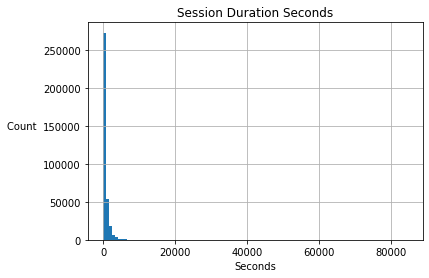

Median Session Length: 300
Mode Session Length: 60


In [26]:
#Obtaining average session length
visits['Session_duration_sec'] = (
    visits['End Ts'] - visits['Start Ts']
).dt.seconds

visits['Session_duration_sec'].hist(bins=100)
plt.title('Session Duration Seconds')
plt.xlabel('Seconds', rotation=0)
plt.ylabel('Count           ', rotation=0)
plt.show()

asl = visits['Session_duration_sec'].median()
asl2 = visits['Session_duration_sec'].mode()
print('Median Session Length:', int(asl))
print('Mode Session Length:', int(asl2))

The median session length for our users is 300 seconds, while the most common session length was 60 seconds. We do not use the mean for analysis as the distrubtion isn't normal.

<a id='3.1.4heading'></a>

#### How often do users come back?

In order to determine this, we'll be obtaining the sticky factor. This metric tells us how loyal the audience is.

*sticky factor = DAU/WAU or sticky factor = DAU/MAU*

In [27]:
#Getting sticky factors
sticky_factor_weekly = dau_total/wau_total*100
print('Weekly sticky factor:', round(float(sticky_factor_weekly), 1), '%')
sticky_factor_monthly = dau_total/mau_total*100
print('Monthly sticky factor:', round(float(sticky_factor_monthly), 1), '%')

Weekly sticky factor: 15.9 %
Monthly sticky factor: 3.9 %


Yandex.Afisha has a 15.9 % sticky factor, that means for every weekly user, they have a 15.9 % shot at turning them into a daily user.

Additionally, of the people who log into Yandex.Afisha at least once a month, 3.9 % of them will log in on any given day.

<a id='3.2heading'></a>

### Sales

<a id='3.2.1heading'></a>

#### When do people start buying?

In [28]:
#Get first order date for every customer
first_order_date_by_customers = orders.groupby('Uid')['Buy Ts', 'Revenue'].min()
first_order_date_by_customers.head()

/tmp/ipykernel_84/612959722.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  first_order_date_by_customers = orders.groupby('Uid')['Buy Ts', 'Revenue'].min()


,Buy Ts,Revenue
Uid,,
313578113262317,2018-01-03 21:51:00,0.55
1575281904278712,2017-06-03 10:13:00,1.22
2429014661409475,2017-10-11 18:33:00,73.33
2464366381792757,2018-01-28 15:54:00,2.44
2551852515556206,2017-11-24 10:14:00,4.67


In [29]:
first_order_date_by_customers = first_order_date_by_customers.reset_index()

In [30]:
first_order_date_by_customers.count()

Uid        36522
Buy Ts     36522
Revenue    36522
dtype: int64

In [31]:
#Adding first purchase date and Revenue to visits dataframe
visits = visits.merge(first_order_date_by_customers, on='Uid', how='left')
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid,Session_year,Session_month,Session_week,Session_date,Session_duration_sec,Buy Ts,Revenue
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,1080,NaT,NaN
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,1680,NaT,NaN
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0,NaT,NaN
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440,2018-03-09 20:25:00,2.33
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27,0,NaT,NaN


In [32]:
#Dropping nulls: dropping customers' visits who didn't buy anything
visits_first_order = visits.dropna()
visits_first_order.head(1)

,Device,End Ts,Source Id,Start Ts,Uid,Session_year,Session_month,Session_week,Session_date,Session_duration_sec,Buy Ts,Revenue
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440,2018-03-09 20:25:00,2.33


In [33]:
#Getting first session from customers
orders_min_Start_Ts = visits_first_order.groupby('Uid')['Start Ts'].min()
orders_min_Start_Ts.head()

Uid
313578113262317    2017-09-18 22:49:00
1575281904278712   2017-06-03 10:13:00
2429014661409475   2017-10-11 17:14:00
2464366381792757   2018-01-27 20:10:00
2551852515556206   2017-11-24 10:14:00
Name: Start Ts, dtype: datetime64[ns]

In [34]:
#Adding _First Session Date column to visits_first_order
visits_first_order = visits_first_order.join(orders_min_Start_Ts, on='Uid', rsuffix=('_First Session Date'))
visits_first_order.head(1)

,Device,End Ts,Source Id,Start Ts,Uid,Session_year,Session_month,Session_week,Session_date,Session_duration_sec,Buy Ts,Revenue,Start Ts_First Session Date
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440,2018-03-09 20:25:00,2.33,2018-03-09 20:05:00


In [35]:
#Renaming two columns
visits_first_order = visits_first_order.rename(columns={'Buy Ts':'First_purchase_datetime',
                                                        'Revenue':'First_purchase_revenue',
                                                       'Start Ts_First Session Date':'First_session_date'})

In [36]:
#Obtaining timespan to buy after first session and column of days people took to convert
visits_first_order['Time_to_buy'] = visits_first_order['First_purchase_datetime'] - visits_first_order['First_session_date']
visits_first_order['Conversion_days'] = visits_first_order['Time_to_buy'].dt.floor('d').dt.days
visits_first_order.head(1)

,Device,End Ts,Source Id,Start Ts,Uid,Session_year,Session_month,Session_week,Session_date,Session_duration_sec,First_purchase_datetime,First_purchase_revenue,First_session_date,Time_to_buy,Conversion_days
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440,2018-03-09 20:25:00,2.33,2018-03-09 20:05:00,0 days 00:20:00,0


In [37]:
#There are duplicate rows: we want one Conversion_days per Uid
visits_first_order[visits_first_order['Uid'] == 16174680259334210214]

,Device,End Ts,Source Id,Start Ts,Uid,Session_year,Session_month,Session_week,Session_date,Session_duration_sec,First_purchase_datetime,First_purchase_revenue,First_session_date,Time_to_buy,Conversion_days
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440,2018-03-09 20:25:00,2.33,2018-03-09 20:05:00,0 days 00:20:00,0
114820,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018,3,10,2018-03-09,1680,2018-03-09 20:25:00,2.33,2018-03-09 20:05:00,0 days 00:20:00,0


In [38]:
print('Dataframe Uid count:', visits_first_order['Uid'].count())
print('Actual total customers:', visits_first_order['Uid'].nunique())

Dataframe Uid count: 97393
Actual total customers: 36522


In [39]:
#Queried visits where first purchases were made
visits_first_order_unique = visits_first_order.query('`Start Ts` <= First_purchase_datetime <= `End Ts`')
print('Confirming new dataframe Uid count:', visits_first_order_unique['Uid'].count())

Confirming new dataframe Uid count: 28893


In [40]:
print('Missing difference:',visits_first_order['Uid'].nunique()-visits_first_order_unique['Uid'].count(), 'first purchases')
print('Remaining first purchases: {:.2%}'.format(visits_first_order_unique['Uid'].count()/visits_first_order['Uid'].nunique()))

Missing difference: 7629 first purchases
Remaining first purchases: 79.11%


***IMPORTANT***

There seems to be an error with the data. 7629 of first purchases do not have a corresponding site visit. This amount corresponds to 20% of the data. This may be due to an error of the automated data entry process for site visits and site purchases.

Look below for example:

In [41]:
#UID 313578113262317 does not have a session that contains their First_purchase_datetime
visits_first_order[['End Ts', 'Start Ts', 'Uid', 'First_purchase_datetime']].sort_values(by='Uid').head()

,End Ts,Start Ts,Uid,First_purchase_datetime
113873,2018-03-11 17:29:00,2018-03-11 17:23:00,313578113262317,2018-01-03 21:51:00
192554,2018-02-18 15:26:00,2018-02-18 15:17:00,313578113262317,2018-01-03 21:51:00
173142,2017-09-18 23:07:00,2017-09-18 22:49:00,313578113262317,2018-01-03 21:51:00
357999,2017-06-03 17:48:00,2017-06-03 17:36:00,1575281904278712,2017-06-03 10:13:00
357823,2017-06-03 10:17:00,2017-06-03 10:13:00,1575281904278712,2017-06-03 10:13:00


In [42]:
#New dataframe, Uid 1575281904278712 does have a session that contains their First_purchase_datetime 
visits_first_order_unique[['End Ts', 'Start Ts', 'Uid', 'First_purchase_datetime']].sort_values(by='Uid').head()

,End Ts,Start Ts,Uid,First_purchase_datetime
357823,2017-06-03 10:17:00,2017-06-03 10:13:00,1575281904278712,2017-06-03 10:13:00
358532,2017-11-24 10:14:19,2017-11-24 10:14:00,2551852515556206,2017-11-24 10:14:00
196600,2018-03-03 12:38:00,2018-03-03 12:08:00,3077748354309989,2018-03-03 12:33:00
328600,2017-09-21 21:22:00,2017-09-21 20:52:00,3605148382144603,2017-09-21 20:56:00
51639,2018-01-09 23:33:00,2018-01-09 23:10:00,4808417689019433,2018-01-09 23:32:00


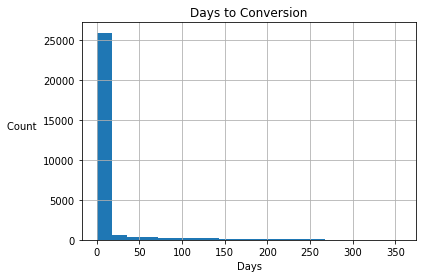

count    28893.000000
mean        10.645589
std         38.617822
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        357.000000
Name: Conversion_days, dtype: float64

In [43]:
#Making histogram for Conversion_days
visits_first_order_unique['Conversion_days'].hist(bins=20)
plt.title('Days to Conversion')
plt.xlabel('Days', rotation=0)
plt.ylabel('Count           ', rotation=0)
plt.show()
visits_first_order_unique['Conversion_days'].describe()

The average person takes 10 days to make a purchase after their first session. However our data contains heavy outliers, indicating that median is a better metric to look at than mean.

The median in this case is a 0 days. However, so is the 75th percentile. Meaning that 75% of people make their first purchase within 1 day after their first session with Yandex.Afisha.

In [44]:
#Checking whether customers from every Source ID made an order
print(visits_first_order_unique['Source Id'].value_counts())
print()
print('Customers from Source ID 6 did not place an order.')

4     7551
3     7099
5     5947
1     3647
2     3031
10    1029
9      588
7        1
Name: Source Id, dtype: int64

Customers from Source ID 6 did not place an order.


In [45]:
# Using Source Id for ads as basis for cohort segmentation
visits_first_order_unique[visits_first_order_unique['Source Id'] == 1]['Time_to_buy'].describe()

count                          3647
mean     12 days 18:15:34.006032355
std      40 days 08:49:55.225110815
min                 0 days 00:00:00
25%                 0 days 00:03:00
50%                 0 days 00:31:00
75%                 1 days 00:07:00
max               343 days 13:36:00
Name: Time_to_buy, dtype: object

In [46]:
# Using Source Id for ads as basis for cohort segmentation
visits_first_order_unique[visits_first_order_unique['Source Id'] == 2]['Time_to_buy'].describe()

count                          3031
mean     17 days 00:09:05.740679643
std      47 days 09:24:26.375492878
min                 0 days 00:00:00
25%                 0 days 00:03:00
50%                 0 days 00:14:00
75%                 2 days 17:46:30
max               352 days 10:35:00
Name: Time_to_buy, dtype: object

In [47]:
# Using Source Id for ads as basis for cohort segmentation
visits_first_order_unique[visits_first_order_unique['Source Id'] == 3]['Time_to_buy'].describe()

count                          7099
mean      9 days 00:13:32.793351176
std      37 days 06:31:59.991804684
min                 0 days 00:00:00
25%                 0 days 00:02:00
50%                 0 days 00:07:00
75%                 0 days 00:23:00
max               357 days 17:28:00
Name: Time_to_buy, dtype: object

In [48]:
# Using Source Id for ads as basis for cohort segmentation
visits_first_order_unique[visits_first_order_unique['Source Id'] == 4]['Time_to_buy'].describe()

count                          7551
mean     10 days 07:43:20.977353992
std      36 days 18:41:39.136681338
min                 0 days 00:00:00
25%                 0 days 00:03:00
50%                 0 days 00:08:00
75%                 0 days 00:33:00
max               352 days 10:38:00
Name: Time_to_buy, dtype: object

In [49]:
# Using Source Id for ads as basis for cohort segmentation
visits_first_order_unique[visits_first_order_unique['Source Id'] == 5]['Time_to_buy'].describe()

count                          5947
mean      8 days 03:29:10.825626366
std      34 days 10:22:27.223930432
min                 0 days 00:00:00
25%                 0 days 00:02:00
50%                 0 days 00:07:00
75%                 0 days 00:28:00
max               354 days 21:48:00
Name: Time_to_buy, dtype: object

In [50]:
# Using Source Id for ads as basis for cohort segmentation
visits_first_order_unique[visits_first_order_unique['Source Id'] == 7]['Time_to_buy'].describe()

count                  1
mean     0 days 00:52:00
std                  NaT
min      0 days 00:52:00
25%      0 days 00:52:00
50%      0 days 00:52:00
75%      0 days 00:52:00
max      0 days 00:52:00
Name: Time_to_buy, dtype: object

In [51]:
# Using Source Id for ads as basis for cohort segmentation
visits_first_order_unique[visits_first_order_unique['Source Id'] == 9]['Time_to_buy'].describe()

count                           588
mean     22 days 11:18:39.795918367
std      53 days 10:26:18.894241978
min                 0 days 00:00:00
25%                 0 days 00:04:00
50%                 0 days 00:14:00
75%                 7 days 00:38:45
max               316 days 06:31:00
Name: Time_to_buy, dtype: object

In [52]:
# Using Source Id for ads as basis for cohort segmentation
visits_first_order_unique[visits_first_order_unique['Source Id'] == 10]['Time_to_buy'].describe()

count                          1029
mean      8 days 22:07:26.413994169
std      38 days 03:32:04.387463097
min                 0 days 00:00:00
25%                 0 days 00:02:00
50%                 0 days 00:07:00
75%                 0 days 00:25:00
max               357 days 01:10:00
Name: Time_to_buy, dtype: object

The median time to place an order after their first session was:
- 0 days and 31 minutes for customers channeled through ad **Source Id 1**
- 0 days and 14 minutes for customers channeled through ad **Source Id 2**
- 0 days and 7 minutes for customers channeled through ad **Source Id 3**
- 0 days and 8 minutes for customers channeled through ad **Source Id 4**
- 0 days and 7 minutes for customers channeled through ad **Source Id 5**
- 0 days and 52 minutes for customers channeled through ad **Source Id 7** (only 1 customer purchased out of 36)
- 0 days 14 minutes for customers channeled through ad **Source Id 9**
- 0 days and 7 minutes for customers channeled through ad **Source Id 10**

Note: out of 6 users from **Source Id 6**, no one bought anything  
Note2: **Source ID 9** had 7 days as its 75th percentile

<a id='3.2.2heading'></a>

#### How many orders do customers make during a given period of time?

In [53]:
#Adding Purchase_month, Purchase_week, and Purchase_day columns
orders['Purchase_month'] = orders['Buy Ts'].astype('datetime64[M]')
orders['Purchase_week'] = orders['Buy Ts'].astype('datetime64[W]')
orders['Purchase_day'] = orders['Buy Ts'].astype('datetime64[D]')
orders.head()

,Buy Ts,Revenue,Uid,Purchase_month,Purchase_week,Purchase_day
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01


In [54]:
#Obtaining number of orders per month
orders_monthly = orders.groupby('Purchase_month')['Buy Ts'].count()
orders_monthly.head()

Purchase_month
2017-06-01    2354
2017-07-01    2363
2017-08-01    1807
2017-09-01    3387
2017-10-01    5679
Name: Buy Ts, dtype: int64

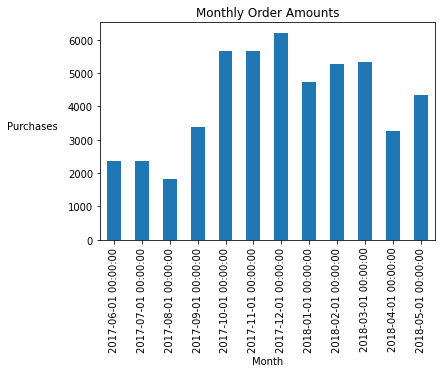

In [55]:
#Bar chart for monthly order amounts
orders_monthly.plot(kind='bar')
plt.title('Monthly Order Amounts')
plt.xlabel('Month')
plt.ylabel('Purchases                    ', rotation=0)
plt.show()

Customers tend to place more orders during the winter months, perhaps due to holiday specials and discounts.

In [56]:
orders_monthly = orders_monthly.reset_index()

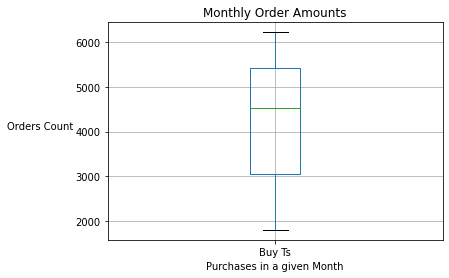

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


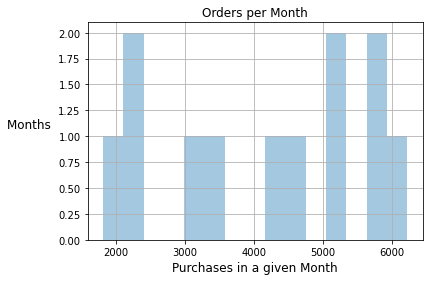

            Buy Ts
count    12.000000
mean   4201.166667
std    1511.972092
min    1807.000000
25%    3045.500000
50%    4533.500000
75%    5409.250000
max    6218.000000


In [57]:
#Making boxplot for monthly order amounts
orders_monthly.boxplot(column = ['Buy Ts'])
plt.title('Monthly Order Amounts')
plt.xlabel('Purchases in a given Month')
plt.ylabel('Orders Count                    ', rotation=0)
plt.show()
#Histogram
sns.distplot(orders_monthly['Buy Ts'], kde = False, bins=15)
plt.title('Orders per Month')
plt.xlabel('Purchases in a given Month', fontsize=12)
plt.ylabel('Months             ', fontsize=12, rotation=0)
plt.grid()
plt.show()
print(orders_monthly.describe())

During a typical month, there are about 4,500 purchases according to our median. This amount is not that far different from the 4,200 mean. There is some seasonality present in our bar chart; there are more purchases around the holiday months.

---

In [58]:
#Obtaining number of orders per week
orders_weekly = orders.groupby('Purchase_week')['Buy Ts'].count()
orders_weekly.head()

Purchase_week
2017-06-01    896
2017-06-08    525
2017-06-15    341
2017-06-22    441
2017-06-29    461
Name: Buy Ts, dtype: int64

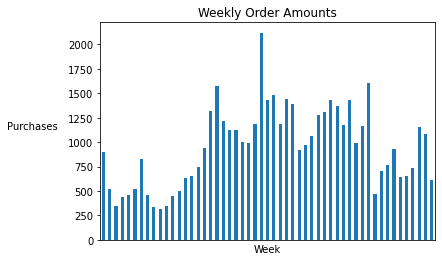

In [59]:
#Bar chart for weekly order amounts
orders_weekly.plot(kind='bar')
plt.title('Weekly Order Amounts')
plt.xlabel('Week')
plt.ylabel('Purchases                    ', rotation=0)
plt.xticks(ticks=[])
plt.show()

In [60]:
orders_weekly = orders_weekly.reset_index()

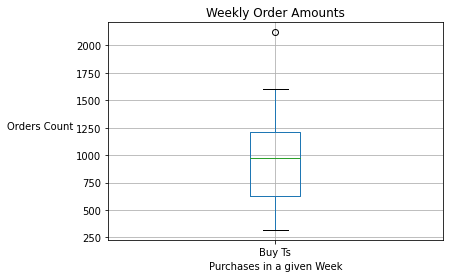

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


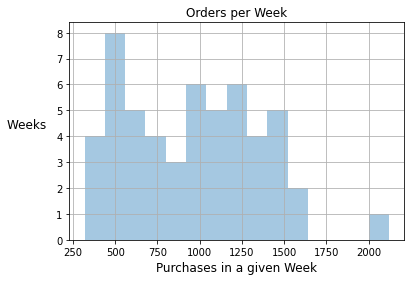

            Buy Ts
count    53.000000
mean    951.207547
std     405.246049
min     319.000000
25%     631.000000
50%     972.000000
75%    1214.000000
max    2120.000000


In [61]:
#Making boxplot for weekly order amounts
orders_weekly.boxplot(column =['Buy Ts'])
plt.title('Weekly Order Amounts')
plt.xlabel('Purchases in a given Week')
plt.ylabel('Orders Count                    ', rotation=0)
plt.show()
#Histogram
sns.distplot(orders_weekly['Buy Ts'], kde = False, bins=15)
plt.title('Orders per Week')
plt.xlabel('Purchases in a given Week', fontsize=12)
plt.ylabel('Weeks             ', fontsize=12, rotation=0)
plt.grid()
plt.show()
print(orders_weekly.describe())

During a typical week, there are about 970 purchases according to our median. This amount is not that far different from the 950 mean. There is some seasonality present in our bar chart; there are more purchases around the holiday weeks.

---

In [62]:
#Obtaining number of orders per day
orders_daily = orders.groupby('Purchase_day')['Buy Ts'].count()
orders_daily = orders_daily.reset_index()
orders_daily.head()

,Purchase_day,Buy Ts
0,2017-06-01,96
1,2017-06-02,111
2,2017-06-03,67
3,2017-06-04,66
4,2017-06-05,161


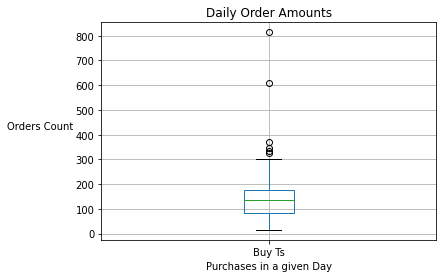

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


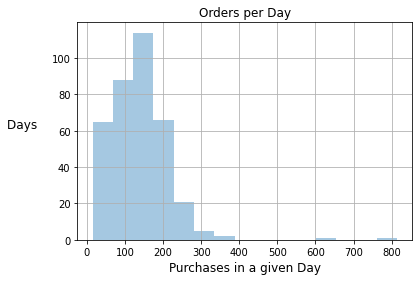

           Buy Ts
count  363.000000
mean   138.881543
std     76.623567
min     15.000000
25%     83.000000
50%    136.000000
75%    177.000000
max    814.000000


In [63]:
#Making boxplot for daily order amounts
orders_daily.boxplot(column =['Buy Ts'])
plt.title('Daily Order Amounts')
plt.xlabel('Purchases in a given Day')
plt.ylabel('Orders Count                    ', rotation=0)
plt.show()
#Histogram
sns.distplot(orders_daily['Buy Ts'], kde = False, bins=15)
plt.title('Orders per Day')
plt.xlabel('Purchases in a given Day', fontsize=12)
plt.ylabel('Days             ', fontsize=12, rotation=0)
plt.grid()
plt.show()
print(orders_daily.describe())

During a typical day, there are about 136 purchases according to our median. This amount is very close from the 138 mean. We did not explore daily purchases with a bar chart due to the extensive amount of days in our data.

In [64]:
#Obtaining first purchase month by customer
first_orders1 = orders.groupby('Uid').agg({'Purchase_month': 'min'}).reset_index()
first_orders1.columns = ['Uid', 'First_purchase_month']
first_orders1.head()

,Uid,First_purchase_month
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01
3,2464366381792757,2018-01-01
4,2551852515556206,2017-11-01


In [65]:
#Obtaining monthly cohorts and their size / calculating the number of new customers (n_buyers) for each month:
cohort_sizes1 = (
    first_orders1.groupby('First_purchase_month')
    .agg({'Uid': 'nunique'})
    .reset_index()
)
cohort_sizes1.columns = ['First_purchase_month', 'N_buyers']
cohort_sizes1.head()

,First_purchase_month,N_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


In [66]:
#Add customers' first-purchase months to the table of orders
orders1 = pd.merge(orders,first_orders1, on='Uid')
orders1.head()

,Buy Ts,Revenue,Uid,Purchase_month,Purchase_week,Purchase_day,First_purchase_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,2017-06-01


In [67]:
#Group the table of orders by month of first purchase and month of purchase and count the purchases.
cohorts1 = orders1.groupby(['First_purchase_month','Purchase_month']).agg({'Buy Ts': 'count'}).reset_index()
cohorts1.head()

,First_purchase_month,Purchase_month,Buy Ts
0,2017-06-01,2017-06-01,2354
1,2017-06-01,2017-07-01,177
2,2017-06-01,2017-08-01,174
3,2017-06-01,2017-09-01,226
4,2017-06-01,2017-10-01,292


In [68]:
#Make the columns show the cohort's age instead of the day of the order
cohorts1['Age'] = (
    cohorts1['Purchase_month'] - cohorts1['First_purchase_month']
) / np.timedelta64(1, 'M')
cohorts1['Age'] = cohorts1['Age'].round().astype('int')
cohorts1.head()

,First_purchase_month,Purchase_month,Buy Ts,Age
0,2017-06-01,2017-06-01,2354,0
1,2017-06-01,2017-07-01,177,1
2,2017-06-01,2017-08-01,174,2
3,2017-06-01,2017-09-01,226,3
4,2017-06-01,2017-10-01,292,4


In [69]:
#Add data on how many users made their first purchases in each month to the cohorts table
report1 = pd.merge(cohort_sizes1, cohorts1, on='First_purchase_month')
report1.head()

,First_purchase_month,N_buyers,Purchase_month,Buy Ts,Age
0,2017-06-01,2023,2017-06-01,2354,0
1,2017-06-01,2023,2017-07-01,177,1
2,2017-06-01,2023,2017-08-01,174,2
3,2017-06-01,2023,2017-09-01,226,3
4,2017-06-01,2023,2017-10-01,292,4


In [70]:
#Adding column Buy TS / N_buyers
report1['Buys_per_customer'] = report1['Buy Ts']/report1['N_buyers']
report1.head()

,First_purchase_month,N_buyers,Purchase_month,Buy Ts,Age,Buys_per_customer
0,2017-06-01,2023,2017-06-01,2354,0,1.163618
1,2017-06-01,2023,2017-07-01,177,1,0.087494
2,2017-06-01,2023,2017-08-01,174,2,0.086011
3,2017-06-01,2023,2017-09-01,226,3,0.111715
4,2017-06-01,2023,2017-10-01,292,4,0.144340


In [71]:
#Converting dtype for better heatmap visualization
report1['First_purchase_month'] = pd.to_datetime(report1['First_purchase_month']).dt.date

In [72]:
#Visualizing the cohorts as a pivot table to make things clear
result1 = report1.pivot_table(
    index='First_purchase_month', columns='Age', values='Buys_per_customer', aggfunc='sum'
)

#Make heatmap contain incremental values, from left to right
result1_sum = result1.cumsum(axis=1)

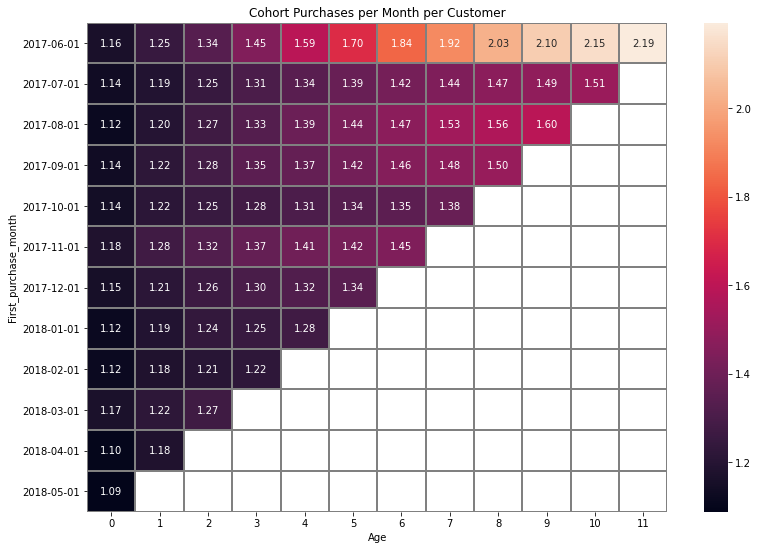

Average Purchases made by customers in cohorts for 6 months from the first order: 1.4341911542792218


In [73]:
#Visualizing cohort purchases on heatmap
plt.figure(figsize=(13, 9))
plt.title('Cohort Purchases per Month per Customer')
sns.heatmap(
    result1_sum,
    annot=True,
    fmt='.2f',
    linewidths=1,
    linecolor='gray',
)
plt.show()

#Getting LTV
m6_cum_purchases = result1.cumsum(axis=1).mean(axis=0)[5]
print('Average Purchases made by customers in cohorts for 6 months from the first order:', m6_cum_purchases)

Our cohorts are listed in the First_purcahse_month column, and we can see how many purchase they make in the ensuing months. Every cohort makes a lot of purchases their first month, and place a fraction of orders the following months. The heatmap allows us to visualize a lack of customer repeating purchases.

<a id='3.2.3heading'></a>

#### What is the average purchase size?

In [74]:
#Obtaining average purchase size by month
orders_monthly_mean = orders.groupby('Purchase_month')['Revenue'].mean()
orders_monthly_mean.head()

Purchase_month
2017-06-01    4.060106
2017-07-01    5.306589
2017-08-01    4.847139
2017-09-01    5.416448
2017-10-01    4.928280
Name: Revenue, dtype: float64

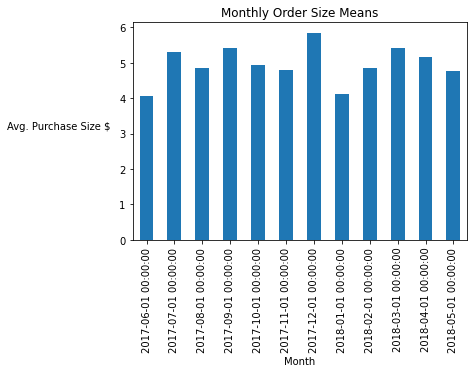

In [75]:
#Bar chart for monthly order amounts
orders_monthly_mean.plot(kind='bar')
plt.title('Monthly Order Size Means')
plt.xlabel('Month')
plt.xticks(rotation=90)
plt.ylabel('Avg. Purchase Size $                                    ', rotation=0)
plt.show()

The bar chart shows us the average purchase size for each month. The month of December happens to have the biggest purchases.

In [76]:
orders_monthly_mean = orders_monthly_mean.reset_index()

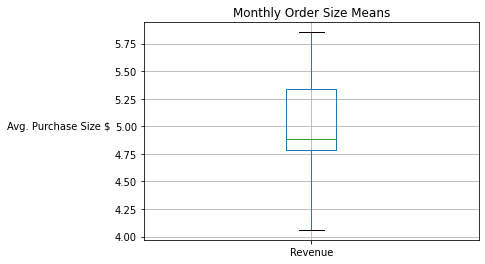

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


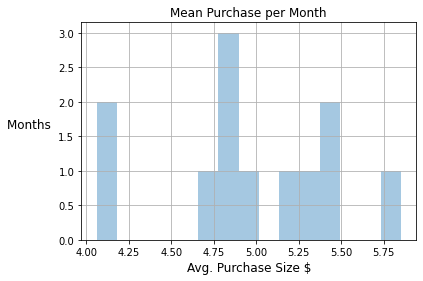

         Revenue
count  12.000000
mean    4.956925
std     0.521265
min     4.060106
25%     4.780459
50%     4.887709
75%     5.333424
max     5.852139


In [77]:
#Making boxplot for monthly order amounts
orders_monthly_mean.boxplot(column =['Revenue'])
plt.title('Monthly Order Size Means')
plt.ylabel('Avg. Purchase Size $                                 ', rotation=0)
plt.show()
#Histogram
sns.distplot(orders_monthly_mean['Revenue'], kde = False, bins=15)
plt.title('Mean Purchase per Month')
plt.xlabel('Avg. Purchase Size $', fontsize=12)
plt.ylabel('Months             ', fontsize=12, rotation=0)
plt.grid()
plt.show()
print(orders_monthly_mean.describe())

During a typical month, the average purchase size was \\$4.88 according to our median, which is very close to our mean of \\$4.95. The month with highest average purchase size was the holiday month of December at a total of \\$5.88. January had the lowest average purchase size at \\$4.06; this is to be expected since customers make a lot of purchases during December deals.

---

In [78]:
#Obtaining average purchase size by week
orders_weekly_mean = orders.groupby('Purchase_week')['Revenue'].mean()
orders_weekly_mean.head()

Purchase_week
2017-06-01    2.842254
2017-06-08    4.831448
2017-06-15    4.478974
2017-06-22    4.760136
2017-06-29    5.314143
Name: Revenue, dtype: float64

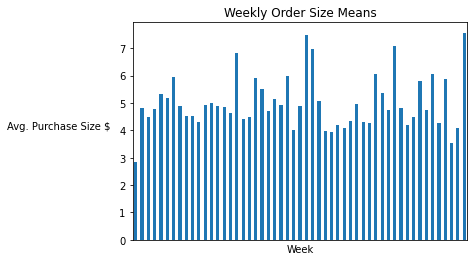

In [79]:
#Bar chart for monthly order amounts
orders_weekly_mean.plot(kind='bar')
plt.title('Weekly Order Size Means')
plt.xlabel('Week')
plt.ylabel('Avg. Purchase Size $                                    ', rotation=0)
plt.xticks(ticks=[])
plt.show()

In [80]:
orders_weekly_mean = orders_weekly_mean.reset_index()

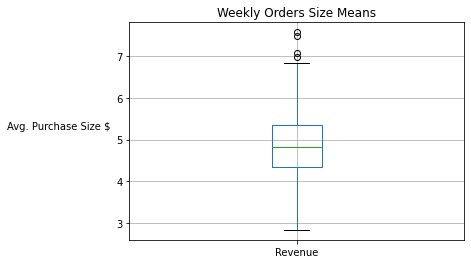

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


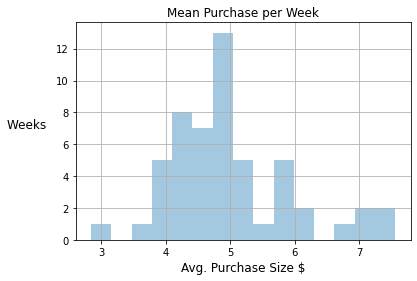

         Revenue
count  53.000000
mean    4.995984
std     0.967512
min     2.842254
25%     4.342249
50%     4.831448
75%     5.343722
max     7.563803


In [81]:
#Making boxplot for monthly order amounts
orders_weekly_mean.boxplot(column =['Revenue'])
plt.title('Weekly Orders Size Means')
plt.ylabel('Avg. Purchase Size $                                  ', rotation=0)
plt.show()
#Histogram
sns.distplot(orders_weekly_mean['Revenue'], kde = False, bins=15)
plt.title('Mean Purchase per Week')
plt.xlabel('Avg. Purchase Size $', fontsize=12)
plt.ylabel('Weeks             ', fontsize=12, rotation=0)
plt.grid()
plt.show()
print(orders_weekly_mean.describe())

During a typical week, the average purchase size was \\$4.83 according to our median, which is very close to our mean of \\$4.99. These sizes are consistent with our monthly charts.

---

In [82]:
#Obtaining average purchase size by week
orders_daily_mean = orders.groupby('Purchase_day')['Revenue'].mean()
orders_daily_mean = orders_daily_mean.reset_index()
orders_daily_mean.head()

,Purchase_day,Revenue
0,2017-06-01,4.056875
1,2017-06-02,2.919910
2,2017-06-03,2.484776
3,2017-06-04,2.957727
4,2017-06-05,2.742174


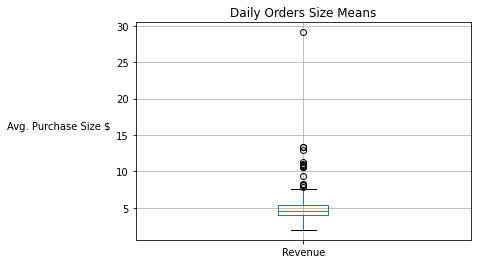

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


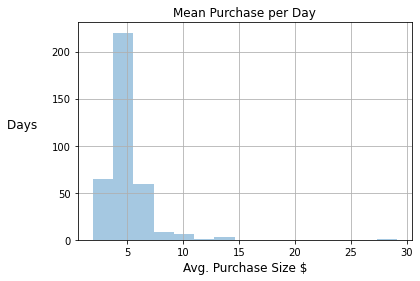

          Revenue
count  363.000000
mean     4.940364
std      2.023098
min      1.948000
25%      3.966686
50%      4.574860
75%      5.412073
max     29.133313


In [83]:
#Making boxplot for monthly order amounts
orders_daily_mean.boxplot(column =['Revenue'])
plt.title('Daily Orders Size Means')
plt.ylabel('Avg. Purchase Size $                                  ', rotation=0)
plt.show()
#Histogram
sns.distplot(orders_daily_mean['Revenue'], kde = False, bins=15)
plt.title('Mean Purchase per Day')
plt.xlabel('Avg. Purchase Size $', fontsize=12)
plt.ylabel('Days             ', fontsize=12, rotation=0)
plt.grid()
plt.show()
print(orders_daily_mean.describe())

During a typical week, the average purchase size was \\$4.57 according to our median, which is very close to our mean of \\$4.94. These sizes are consistent with our monthly charts. We did not explore daily purchase sizes with a bar chart due to the extensive amount of days in our data.

<a id='3.2.4heading'></a>

#### How much money do they bring? (LTV)

In [84]:
#Obtaining first purchase month by customer
first_orders = orders.groupby('Uid').agg({'Purchase_month': 'min'}).reset_index()
first_orders.columns = ['Uid', 'First_purchase_month']
first_orders.head()

,Uid,First_purchase_month
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01
3,2464366381792757,2018-01-01
4,2551852515556206,2017-11-01


In [85]:
#Obtaining monthly cohorts and their size / calculating the number of new customers (n_buyers) for each month:
cohort_sizes = (
    first_orders.groupby('First_purchase_month')
    .agg({'Uid': 'nunique'})
    .reset_index()
)
cohort_sizes.columns = ['First_purchase_month', 'N_buyers']
cohort_sizes.head()

,First_purchase_month,N_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


In [86]:
#Add customers' first-purchase months to the table of orders
orders_ = pd.merge(orders,first_orders, on='Uid')
orders_.head()

,Buy Ts,Revenue,Uid,Purchase_month,Purchase_week,Purchase_day,First_purchase_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,2017-06-01


In [87]:
#Group the table of orders by month of first purchase and month of purchase and sum up the revenue.
cohorts = orders_.groupby(['First_purchase_month','Purchase_month']).agg({'Revenue': 'sum'}).reset_index()
cohorts.head()

,First_purchase_month,Purchase_month,Revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


In [88]:
#Add data on how many users made their first purchases in each month to the cohorts table
report = pd.merge(cohort_sizes, cohorts, on='First_purchase_month')
report.head()

,First_purchase_month,N_buyers,Purchase_month,Revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58


Gross margin = gross profit / revenue

In [89]:
#Obtaining margin rate
margin_rate = (orders['Revenue'].sum() - costs['costs'].sum()) / costs['costs'].sum()
print('Margin rate:', margin_rate)

Margin rate: -0.23418546051576578


#Gross profit
report['GP'] = report['Revenue'] * margin_rate

#Make the columns show the cohort's age instead of the month of the order
report['Age'] = (
    report['Purchase_month'] - report['First_purchase_month']
) / np.timedelta64(1, 'M')
report['Age'] = report['Age'].round().astype('int')

#Calculating lifetime value
report['LTV'] = report['GP'] / report['N_buyers']

report.head()

In [90]:
#Make the columns show the cohort's age instead of the month of the order
report['Age'] = (
    report['Purchase_month'] - report['First_purchase_month']
) / np.timedelta64(1, 'M')
report['Age'] = report['Age'].round().astype('int')

#Calculating lifetime value
report['LTV'] = report['Revenue'] / report['N_buyers']

report.head()

,First_purchase_month,N_buyers,Purchase_month,Revenue,Age,LTV
0,2017-06-01,2023,2017-06-01,9557.49,0,4.724414
1,2017-06-01,2023,2017-07-01,981.82,1,0.485329
2,2017-06-01,2023,2017-08-01,885.34,2,0.437637
3,2017-06-01,2023,2017-09-01,1931.30,3,0.954671
4,2017-06-01,2023,2017-10-01,2068.58,4,1.022531


In [91]:
#Visualizing the cohorts as a pivot table to make things clear
result = report.pivot_table(
    index='First_purchase_month', columns='Age', values='LTV', aggfunc='mean'
).round()

result = result.fillna('')
result

Age,0,1,2,3,4,5,6,7,8,9,10,11
First_purchase_month,,,,,,,,,,,,
2017-06-01,5.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2017-07-01,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
2017-08-01,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,
2017-09-01,6.0,1.0,1.0,4.0,0.0,1.0,1.0,0.0,0.0,,,
2017-10-01,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,,,,
2017-11-01,5.0,0.0,0.0,0.0,0.0,0.0,0.0,,,,,
2017-12-01,5.0,0.0,1.0,1.0,0.0,0.0,,,,,,
2018-01-01,4.0,0.0,0.0,0.0,0.0,,,,,,,
2018-02-01,4.0,0.0,0.0,0.0,,,,,,,,


In [92]:
#Next step: calculate CAC for each cohort. First, find the total expenses for each month
costs['month'] = costs['dt'].astype('datetime64[M]')
monthly_costs = costs.groupby('month').sum()
monthly_costs

,source_id,costs
month,,
2017-06-01,1020,18015.00
2017-07-01,1054,18240.59
2017-08-01,1054,14790.54
2017-09-01,1020,24368.91
2017-10-01,1054,36322.88
2017-11-01,1020,37907.88
2017-12-01,1054,38315.35
2018-01-01,1054,33518.52
2018-02-01,952,32723.03


In [93]:
#Add the data on costs to report
report_ = pd.merge(
    report, monthly_costs, left_on='First_purchase_month', right_on='month'
)
report_.head()

,First_purchase_month,N_buyers,Purchase_month,Revenue,Age,LTV,source_id,costs
0,2017-06-01,2023,2017-06-01,9557.49,0,4.724414,1020,18015.0
1,2017-06-01,2023,2017-07-01,981.82,1,0.485329,1020,18015.0
2,2017-06-01,2023,2017-08-01,885.34,2,0.437637,1020,18015.0
3,2017-06-01,2023,2017-09-01,1931.30,3,0.954671,1020,18015.0
4,2017-06-01,2023,2017-10-01,2068.58,4,1.022531,1020,18015.0


In [94]:
#Obtaining Customer Aquisition Cost (CAC)
report_['CAC'] = report_['costs'] / report_['N_buyers']
#Obtaining Return On Marketing Investment (ROMI)
report_['ROMI'] = report_['LTV'] / report_['CAC']

report_.head()

,First_purchase_month,N_buyers,Purchase_month,Revenue,Age,LTV,source_id,costs,CAC,ROMI
0,2017-06-01,2023,2017-06-01,9557.49,0,4.724414,1020,18015.0,8.905091,0.530530
1,2017-06-01,2023,2017-07-01,981.82,1,0.485329,1020,18015.0,8.905091,0.054500
2,2017-06-01,2023,2017-08-01,885.34,2,0.437637,1020,18015.0,8.905091,0.049145
3,2017-06-01,2023,2017-09-01,1931.30,3,0.954671,1020,18015.0,8.905091,0.107205
4,2017-06-01,2023,2017-10-01,2068.58,4,1.022531,1020,18015.0,8.905091,0.114825


In [95]:
#Converting dtype for better heatmap visualization
report_['First_purchase_month'] = pd.to_datetime(report_['First_purchase_month']).dt.date

In [96]:
#Obtaining the monthly Return On Marketing Investment
result_ROMI = report_.pivot_table(index='First_purchase_month',
                             columns='Age',
                             values='ROMI',
                             aggfunc='mean')
#Make heatmap contain incremental values, from left to right
result_ROMI_sum = result_ROMI.cumsum(axis=1)

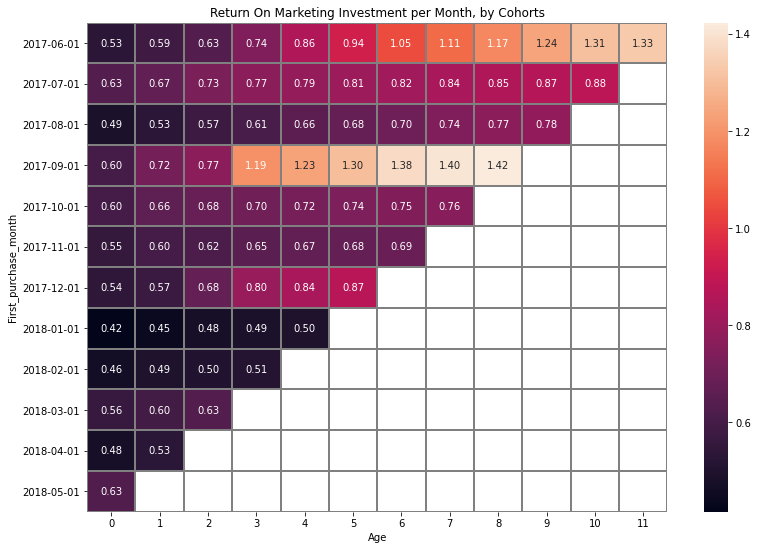

Average ROMI for 12 months from the first order: 1.333982237024701


In [97]:
#Visualizing the monthly Return On Marketing Investment
plt.figure(figsize=(13, 9))
plt.title('Return On Marketing Investment per Month, by Cohorts')
sns.heatmap(
    result_ROMI_sum,
    annot=True,
    fmt='.2f',
    linewidths=1,
    linecolor='gray',
)
plt.show()


#Getting ROMI
m1_cum_ltv = result_ROMI.cumsum(axis=1).mean(axis=0)[11]
print('Average ROMI for 12 months from the first order:', m1_cum_ltv)

In [98]:
#Obtaining the monthly Customer Lifetime Value
result_LTV = report_.pivot_table(index='First_purchase_month',
                             columns='Age',
                             values='LTV',
                             aggfunc='mean')

#Make heatmap contain incremental values, from left to right
result_LTV_sum = result_LTV.cumsum(axis=1)

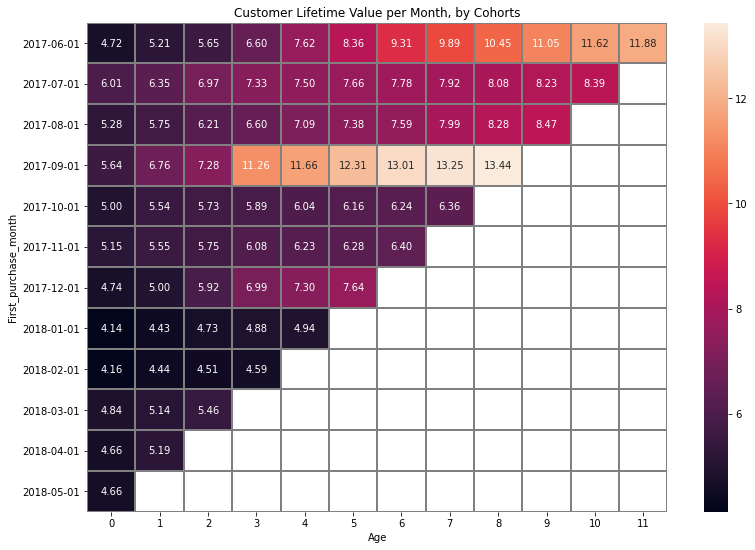

Average LTV for 12 months from the first order: 11.879233811171527


In [99]:
#Visualizing the monthly Customer Lifetime Value on heatmap
plt.figure(figsize=(13, 9))
plt.title('Customer Lifetime Value per Month, by Cohorts')
sns.heatmap(
    result_LTV_sum,
    annot=True,
    fmt='.2f',
    linewidths=1,
    linecolor='gray',
)
plt.show()

#Getting LTV
m12_cum_ltv = result_LTV.cumsum(axis=1).mean(axis=0)[11]
print('Average LTV for 12 months from the first order:', m12_cum_ltv)

Yandex.Afisha obtains \\$11.88 per customer during a 12 month period. Moreover, their return on marketing investment is \\$1.33 per customer.

<a id='3.3heading'></a>

### Marketing

<a id='3.3.1heading'></a>

#### How much money was spent? Overall/per source/over time

In [100]:
#Obtaining the monthly costs for each source_id
monthly_costs_per_source = costs.pivot_table(index=['month'], columns='source_id', values='costs', aggfunc='sum')

new_col = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
idx=5
monthly_costs_per_source.insert(loc=idx, column=7, value=new_col)

#Changing index data type, for cleaner visualization which omits hours, minutes, seconds
monthly_costs_per_source = monthly_costs_per_source.reset_index()
monthly_costs_per_source['month'] = monthly_costs_per_source['month'].dt.date
monthly_costs_per_source = monthly_costs_per_source.set_index('month')

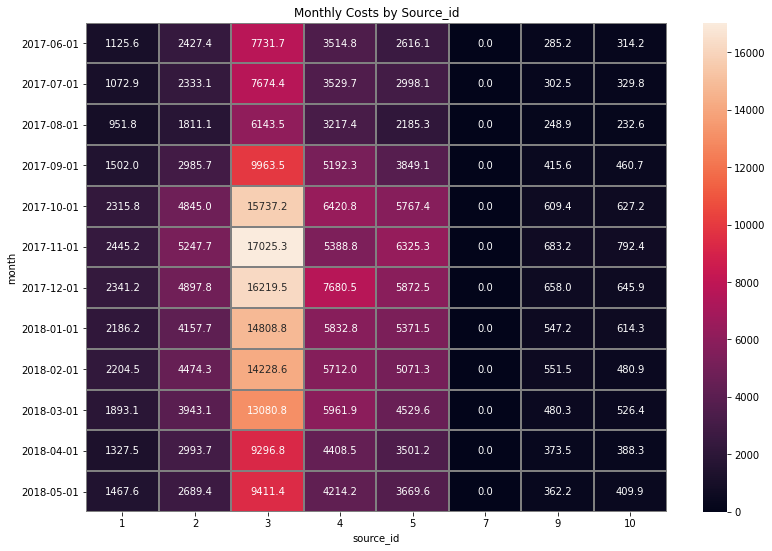

In [101]:
#Plotting heatmap monthly costs for each source_id
plt.figure(figsize=(13, 9))
plt.title('Monthly Costs by Source_id')
sns.heatmap(
    monthly_costs_per_source,
    annot=True,
    fmt='.1f',
    linewidths=1,
    linecolor='gray',
) 
plt.show()

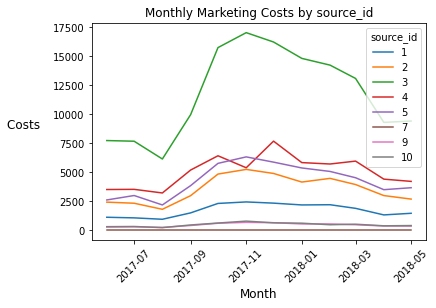

Total spent on marketing: 329131.62


In [102]:
#Plotting timeseries for monthly marketing costs by source_id
monthly_costs_per_source.plot()
plt.title('Monthly Marketing Costs by source_id')
plt.xlabel('Month', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel('Costs             ', fontsize=12, rotation=0)
plt.show()
print('Total spent on marketing:', monthly_costs_per_source.sum().sum())

In [103]:
#Total marketing costs per month
monthly_costs_total = monthly_costs_per_source.sum(axis=1)

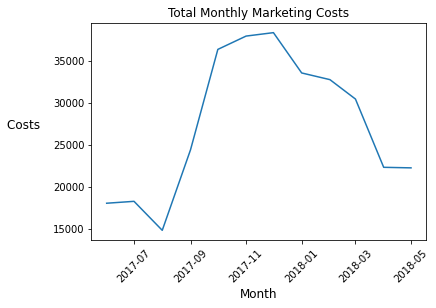

Total spent on marketing: 329131.62


In [104]:
#Plotting timeseries for total monthly marketing costs
monthly_costs_total.plot()
plt.title('Total Monthly Marketing Costs')
plt.xlabel('Month', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel('Costs             ', fontsize=12, rotation=0)
plt.show()
print('Total spent on marketing:', monthly_costs_total.sum())

- Source ID 3 greatly exceeds in marketing costs for every month.
- Source IDs 4, 5, and 2 come in second place with similar costs.
- Source IDs 1, 9, and 10 have minimal costs.

- Total marketing costs substantially increase during winter months. Unsurprising finding since most purchases are made in winter months by customers.
    - We see a similar cost tend between Total Monthly Marketing Costs and marketing costs for Source ID 3.

<a id='3.3.2heading'></a>

#### How much did customer acquisition from each of the sources cost?

In [105]:
#Obtaining the first source for each Uid (customer)
first_sources = visits.sort_values('Start Ts').groupby('Uid').first()
first_sources = first_sources[['Source Id']]
first_sources.head()

,Source Id
Uid,
11863502262781,3
49537067089222,2
297729379853735,3
313578113262317,2
325320750514679,5


In [106]:
visits_first_order_unique = pd.merge(visits_first_order_unique, first_sources, on='Uid')
visits_first_order_unique.head()

,Device,End Ts,Source Id_x,Start Ts,Uid,Session_year,Session_month,Session_week,Session_date,Session_duration_sec,First_purchase_datetime,First_purchase_revenue,First_session_date,Time_to_buy,Conversion_days,Source Id_y
0,touch,2018-02-12 20:30:00,2,2018-02-12 19:24:00,18188358787673499603,2018,2,7,2018-02-12,3960,2018-02-12 19:48:00,0.06,2018-02-10 12:17:00,2 days 07:31:00,2,3
1,desktop,2018-03-12 23:25:00,3,2018-03-12 23:13:00,15857957287537270437,2018,3,11,2018-03-12,720,2018-03-12 23:17:00,1.83,2017-09-22 21:16:00,171 days 02:01:00,171,2
2,desktop,2018-02-25 23:43:00,5,2018-02-25 23:35:00,9344114199116964256,2018,2,8,2018-02-25,480,2018-02-25 23:36:00,0.98,2018-02-25 23:35:00,0 days 00:01:00,0,5
3,desktop,2018-03-28 22:35:00,3,2018-03-28 22:18:00,2489709968553445691,2018,3,13,2018-03-28,1020,2018-03-28 22:25:00,0.30,2018-03-28 22:18:00,0 days 00:07:00,0,3
4,desktop,2018-02-12 17:23:00,3,2018-02-12 17:23:00,14190261731932459700,2018,2,7,2018-02-12,0,2018-02-12 17:23:00,4.89,2018-02-12 17:23:00,0 days 00:00:00,0,3


In [107]:
#Renaming Source Id_y column 
visits_first_order_unique = visits_first_order_unique.rename(columns={'Source Id_y':'First Source Id'})

#Adding column for First_purchase_month
visits_first_order_unique['First_purchase_month'] = visits_first_order_unique['First_purchase_datetime'].astype('datetime64[M]')

visits_first_order_unique.head(1)

,Device,End Ts,Source Id_x,Start Ts,Uid,Session_year,Session_month,Session_week,Session_date,Session_duration_sec,First_purchase_datetime,First_purchase_revenue,First_session_date,Time_to_buy,Conversion_days,First Source Id,First_purchase_month
0,touch,2018-02-12 20:30:00,2,2018-02-12 19:24:00,18188358787673499603,2018,2,7,2018-02-12,3960,2018-02-12 19:48:00,0.06,2018-02-10 12:17:00,2 days 07:31:00,2,3,2018-02-01


In [108]:
#Number of visitors by source id by month
visits_by_source = visits_first_order_unique.pivot_table(index=['First_purchase_month'], columns='First Source Id', values='Uid', aggfunc='count')
visits_by_source = visits_by_source.fillna(0)

#Changing index data type, for cleaner visualization which omits hours, minutes, seconds
visits_by_source = visits_by_source.reset_index()
visits_by_source['First_purchase_month'] = visits_by_source['First_purchase_month'].dt.date
visits_by_source = visits_by_source.set_index('First_purchase_month')

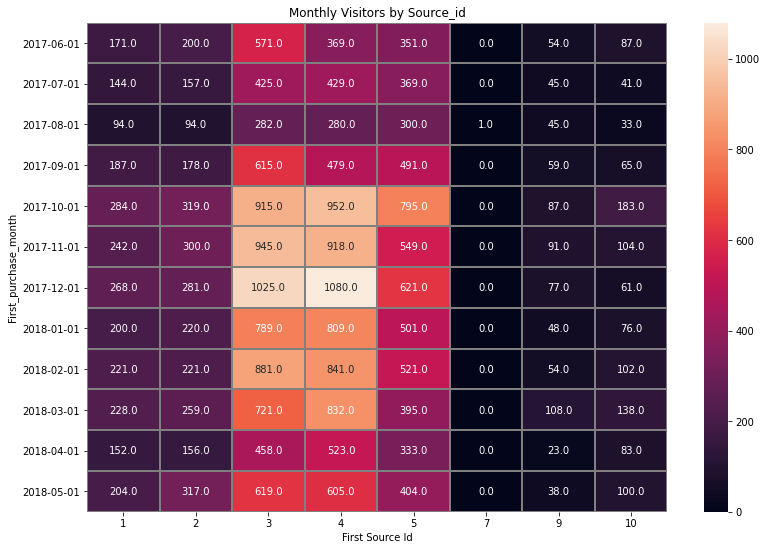

In [109]:
#Plotting heatmap Number of visitors by source id by month
plt.figure(figsize=(13, 9))
plt.title('Monthly Visitors by Source_id')
sns.heatmap(
    visits_by_source,
    annot=True,
    fmt='.1f',
    linewidths=1,
    linecolor='gray',
) 
plt.show()

In [110]:
#Obtaining monthly customer aquisition cost per source_id
CAC = monthly_costs_per_source/visits_by_source

#Fillna with 0
CAC = CAC.fillna(0)

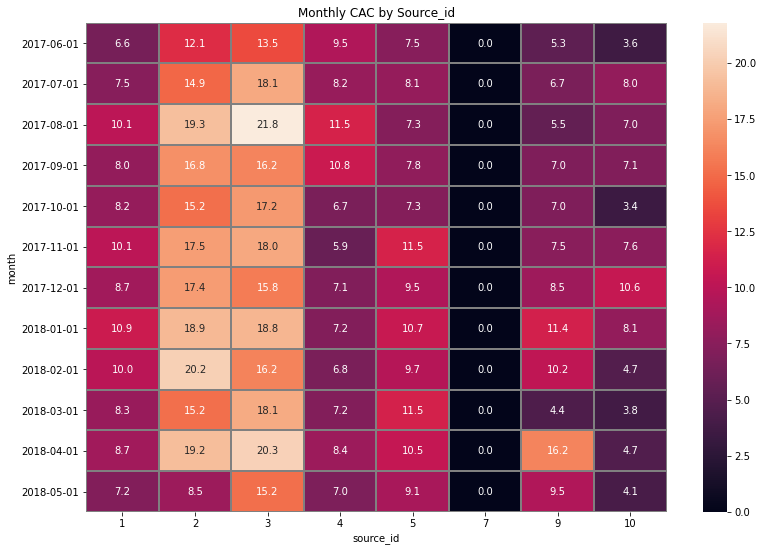

In [111]:
#Plotting heatmap Monthly CAC by Source_id
plt.figure(figsize=(13, 9))
plt.title('Monthly CAC by Source_id')
sns.heatmap(
    CAC,
    annot=True,
    fmt='.1f',
    linewidths=1,
    linecolor='gray',
) 
plt.show()

- CAC for Source ID 3 is much higher than all other channels.
- CAC for Source ID 2 is also quite large.
- CAC for Source ID 9 on April is unusually high
- All other marketing channels have standarized costs

<a id='3.3.3heading'></a>

#### How worthwhile were the investments? (ROI)

Operating profit = gross profit - operating expenses  
Net profit = operating profit - taxes and loans  
ROI = (net profit − investments) / investments

In [112]:
#Calculating total revenue, total costs, and total loss
print('Total revenue: $', int(orders['Revenue'].sum()))
print('Total costs: $', int(costs['costs'].sum()))
print('Total profit/loss: $', int(orders['Revenue'].sum() - costs['costs'].sum()))
#Calculating ROI
print('ROI: {:.2%}'.format(margin_rate))

Total revenue: $ 252053
Total costs: $ 329131
Total profit/loss: $ -77077
ROI: -23.42%


In [113]:
#Pivot containing revenue for first purchases by month - no need for heatmap
first_purchases_visits_pivot = visits_first_order_unique.pivot_table(index=['First_purchase_month'], columns='First Source Id', values='First_purchase_revenue', aggfunc='sum')
first_purchases_visits_pivot 

First Source Id,1,2,3,4,5,7,9,10
First_purchase_month,,,,,,,,
2017-06-01,655.30,484.10,1646.37,1387.95,1418.28,NaN,119.65,168.82
2017-07-01,732.31,763.56,1863.20,2022.54,1618.03,NaN,134.06,115.04
2017-08-01,429.66,398.95,1188.87,1161.52,1186.28,1.22,97.08,115.30
2017-09-01,696.27,555.26,2819.83,1633.03,2195.32,NaN,184.58,113.60
2017-10-01,1130.54,1149.80,3186.59,3362.14,3579.69,NaN,277.55,408.94
2017-11-01,878.38,1165.21,3355.83,3575.53,2138.81,NaN,252.87,374.79
2017-12-01,918.12,1259.89,3564.70,3802.52,2603.29,NaN,248.75,200.28
2018-01-01,788.65,730.36,2801.11,2617.57,1762.08,NaN,97.92,229.95
2018-02-01,770.61,988.08,2874.48,2996.89,1930.51,NaN,245.84,229.90


In [114]:
#Getting % of total revenue for first time purchase
print('Revenue on first purchases:', int(first_purchases_visits_pivot.sum().sum()))
print('Total revenue:', int(orders['Revenue'].sum()))
print('First purchases amount of Total Revenue: {:.2%}'.format(first_purchases_visits_pivot.sum().sum()/orders['Revenue'].sum()))

Revenue on first purchases: 108095
Total revenue: 252053
First purchases amount of Total Revenue: 42.89%


Yandex-Afisha is experiencing a loss of investment of -23.42%.

A staggering 43% of revenue for the year period is made up of first-time purchases! Yandex-Afisha needs to increase efforts for more repeat purchases.

<a id='4heading'></a>

## General Conslusion

In this report, we analyzed data from Yandex.Afisha ranging from 2017-06-01 to 2018-05-31. We determined that Yandex.Afisha has a total of 23228 monthly active users with a median session length of 300 seconds, but 60 seconds was the most popular length. We also know that of the people who log into Yandex.Afisha at least once a month, 3.9% of them will log in on any given day.

We found out with the help of histograms that 75% of people make their first purchase within 1 day after their first session with Yandex.Afisha. This holds true for most source channels (give or take an extra day) except Source ID 9; it has 7 days as its 75th percentile. People take disproportionately longer to buy on this channel.

During a typical month, there are about 4,500 purchases with an average purchase size of \\$4.88. This amount is not that far different from the 4,200 mean. There is some seasonality present in our bar charts; there are more purchases around the holiday months, and January had the lowest average purchase size at $4.06 since customers make a lot of purchases during the December deals.

We found with the extensive use of aggregate functions and pivot tables that Yandex.Afisha is losing money! Customer Lifetime Value is \\$11.83 during the 12 month period. Moreover, their return on marketing investment is \\$1.33 per customer.

We have the following financials:  
- Total revenue: \\$ 252053
- Total costs: \\$ 329131
- Total profit/loss: \\$ -77077
- ROI: -23.42%

Yandex.Afisha should consider cutting down marketing costs for **Source ID 3**. It proves to be the sourcing channel with highest Customer Aquisition Cost in every month. Instead, Yandex.Afisha should opt to invest more money in lower-cost channels that bring in similar amounts of customers, such as **sources 4 and 5**. Additionally, **Source ID 1** is a another good channel to invest in as it brings in the same amount of customers as **Source ID 2** with lower costs. **Source ID 7** has a very poor conversion rate, as only 1 of 36 customers obtained through that channel made a purchase. **Source IDs 9 and 10** have significantly fewer visits than the all other channels, but since those channels have relatively low CACs, it could be worthwhile to increase marketing efforts for both sources.

Yandex.Afisha needs to increase efforts marketing efforts for repeat purchases. With the help of aggregate findings, we identified that about 43% of revenue for the year period is made up of first-time purchases. Emailing efforts as reminders to visit Yandex.Afish could prove useful.